# Proyek UAS Multimedia 2024: Image Segmentation dengan LACSS dan Watershed
dikerjakan oleh Kelompok 10
Nama|NPM|Peran
---|---| ---
Muhammad Naufal Faza|2006577252|Pengetikan LACSS, inference, laporan
Michael Harditya|2006577265|Pengetikan watershed,model loading, dokumentasi

Notebook ini akan melakukan beberapa demonstrasi dalam melakukan proses training dan inference pada LACSS, serta membandingkannya dengan metode Watershed. Dataset yang digunakan adalah dataset dari [Cell Image Library](http://www.cellimagelibrary.org/home).

## Instalasi dan persiapan library

In [1]:
!pip install lacss

from os.path import join
import imageio.v2 as imageio
import json
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from skimage.color import label2rgb
from tqdm import tqdm
from pathlib import Path
from dataclasses import asdict

import lacss.data
from lacss.train import LacssTrainer, VMapped, TFDatasetAdapter
from lacss.ops import patches_to_label
from lacss.utils import show_images
import warnings
warnings.filterwarnings('ignore')

2024-06-13 21:17:29.253248: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-13 21:17:29.974814: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Mendefinisikan Data Pipeline (dengan Tensorflow Dataset)

--2024-06-13 21:19:03--  https://data.mendeley.com/public-files/datasets/894mmsd9nj/files/568e524f-9a95-45a6-9f80-3619969c2a37/file_downloaded
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/305fe4d3-50bf-4e9b-89c7-fca353116d70 [following]
--2024-06-13 21:19:06--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/305fe4d3-50bf-4e9b-89c7-fca353116d70
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 3.5.66.167, 52.92.36.218, 52.92.3.122, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files

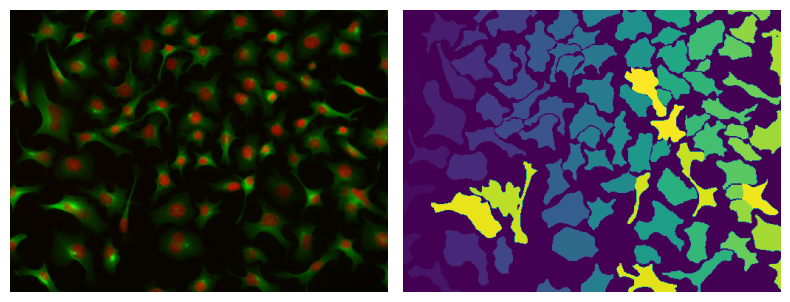

In [3]:
# Download dataset dan unzip data tersebut

!wget -c https://data.mendeley.com/public-files/datasets/894mmsd9nj/files/568e524f-9a95-45a6-9f80-3619969c2a37/file_downloaded -O images.zip

import zipfile

data_path = Path('image_data')
with zipfile.ZipFile('images.zip', "r") as f:
    f.extractall(data_path)

img = imageio.imread(data_path / 'train' / '000_img.png')
gt = imageio.imread(data_path / 'train'/ '000_masks.png')

show_images([
    img,
    gt,
])

LACSS menggunakan training data yang berasal dari python generator dengan format:
```
x_data, y_data = (
  {
    "image": ndarray[B, W, H, C],
    "gt_locations": ndarray[B, N, 2]
  },
  {
    "gt_labels": ndarray[B, W, H]
  }
)
```
Kode berikut akan mengatur sebuah data pipeline dengan `tensorflow.dataset` agar menyesuaikan format tersebut.

In [4]:
from os.path import join

def parser(data):
    image = data['image']
    label = data['label']
    locations = data['centroids']

    height = tf.shape(image)[0]
    width = tf.shape(image)[1]

    # Augmentasi pada gambar untuk proses training
    if tf.random.uniform(()) >= 0.5:
        image = tf.image.flip_left_right(image)
        label = label[:, ::-1]
        locations = locations * [1, -1] + [0, width]

    if tf.random.uniform(()) >= 0.5:
        image = tf.image.flip_up_down(image)
        label = label[::-1, :]
        locations = locations * [-1, 1] + [height, 0]

    # melakukan padding agar dataset memiliki ukuran yang sama
    n_pad = 512 - len(locations)
    locations = tf.pad(locations, [[0, n_pad], [0,0]], constant_values=-1)

    return (
        dict(
            image = image,
            gt_locations = locations, 
        ),
        dict(
            gt_labels = label,
        ),
    )

batch_size = 1
imgfiles = [join(data_path, 'train', f'{k:03d}_img.png') for k in range(89)]
maskfiles = [join(data_path, 'train', f'{k:03d}_masks.png') for k in range(89)]

# membuat tensorflow dataset dari file dataset yang sudah di download sebelumnya 
ds = (
    lacss.data.dataset_from_img_mask_pairs(imgfiles, maskfiles)
    .map(parser)
    .repeat()
    .batch(batch_size)
)

ds.element_spec

2024-06-13 21:19:12.737030: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


({'image': TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None),
  'gt_locations': TensorSpec(shape=(None, None, 2), dtype=tf.float32, name=None)},
 {'gt_labels': TensorSpec(shape=(None, None, None), dtype=tf.int32, name=None)})

## Inisiasi Trainer

Kelas ```lacss.train.LacssTrainer``` adalah interface yang digunakan untuk training, terdapat beberapa hal yang diperlukan untuk diinisiasi juga:
- konfigurasi dictionary untuk melakukan *override* pada hyperparameter model.
- Random seed value untuk mengontrol proses SGD (*Stochastic Gradient Descent*)
- Strategi training lainnya, pada contoh ini menggunakan satu GPU untuk training pada batch data.

In [7]:
# Konfigurasi model untuk melakukan override pada hyperparameter 
cfg = {
  "backbone": {
    "drop_path_rate": 0.4
  },
  "segmentor": {
    "instance_crop_size": 128
  }
}

# Inisialisasi trainer
trainer = LacssTrainer(
    cfg,
    seed=1234, # seed untuk random number generator
    strategy=VMapped,
)

from pprint import pprint

print("---Current model configuration---")
pprint(
    asdict(trainer.model.principal), 
)

---Current model configuration---
{'backbone': {'depths': (3, 3, 27, 3),
              'dims': (96, 192, 384, 768),
              'drop_path_rate': 0.4,
              'layer_scale_init_value': 1e-06,
              'name': None,
              'out_channels': 384,
              'parent': None,
              'patch_size': 4},
 'detector': {'max_proposal_offset': 12,
              'name': None,
              'parent': None,
              'test_max_output': 2560,
              'test_min_score': 0.2,
              'test_nms_threshold': 8.0,
              'test_pre_nms_topk': -1,
              'train_max_output': 2560,
              'train_min_score': 0.2,
              'train_nms_threshold': 8.0,
              'train_pre_nms_topk': -1},
 'lpn': {'conv_spec': ((384, 384, 384, 384), ()),
         'detection_roi': 8.0,
         'feature_levels': (4, 3, 2),
         'name': None,
         'parent': None},
 'name': None,
 'parent': None,
 'segmentor': {'conv_spec': ((384, 384, 384), (64,)),
     

## Training

In [8]:
n_steps = 15000
validation_interval = 3000

trainer.do_training(
  TFDatasetAdapter(ds),
  n_steps = n_steps,
  validation_interval = validation_interval,
)

2024-06-13 20:45:19.891404: W external/tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-13 20:45:20.070663: W external/tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 72.77GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


Current step 0 going to 3000


  0%|                                                                                              | 0/3000 [00:00<?, ?it/s]2024-06-13 20:45:44.796328: W external/tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-13 20:45:44.863035: W external/tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 72.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
100%|███████████████████████████████████████████████████████████████████████████████████| 3000/3000 [03:30<00:00, 14.28it/s]


Losses: (lpn_loss: 0.0262, segmentation_loss: 0.0346, collaborator_segm_loss: 0.0000, collaborator_border_loss: 0.0000, aux_size_loss: 0.0000)
Current step 3000 going to 6000


100%|███████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:52<00:00, 17.36it/s]


Losses: (lpn_loss: 0.0106, segmentation_loss: 0.0169, collaborator_segm_loss: 0.0000, collaborator_border_loss: 0.0000, aux_size_loss: 0.0000)
Current step 6000 going to 9000


100%|███████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:28<00:00, 20.22it/s]


Losses: (lpn_loss: 0.0056, segmentation_loss: 0.0129, collaborator_segm_loss: 0.0000, collaborator_border_loss: 0.0000, aux_size_loss: 0.0000)
Current step 9000 going to 12000


100%|███████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:28<00:00, 20.26it/s]


Losses: (lpn_loss: 0.0039, segmentation_loss: 0.0111, collaborator_segm_loss: 0.0000, collaborator_border_loss: 0.0000, aux_size_loss: 0.0000)
Current step 12000 going to 15000


100%|███████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:28<00:00, 20.26it/s]

Losses: (lpn_loss: 0.0029, segmentation_loss: 0.0099, collaborator_segm_loss: 0.0000, collaborator_border_loss: 0.0000, aux_size_loss: 0.0000)


## Visualisasi hasil prediksi

In [12]:
# Save model
trainer.save('saved_model_segmentation.pkl')

2024-06-13 21:00:33.194916: W external/tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 20.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


[Text(0.5, 1.0, 'Input'),
 Text(0.5, 1.0, 'Prediction'),
 Text(0.5, 1.0, 'Ground Truth')]

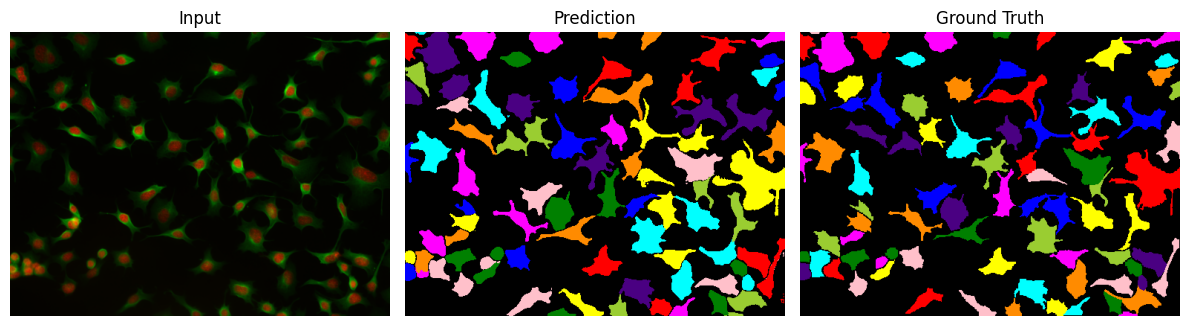

In [9]:
# Baca gambar pada testing set
image = imageio.imread(data_path/'test'/'000_img.png')
gt = imageio.imread(data_path/'test'/'000_masks.png')

# prediksi pada testing set
model_output = trainer.model.apply(
    dict(params = trainer.parameters),
    image = image / 255,
)
pred = patches_to_label(
    model_output, 
    input_size=image.shape[:2]
)
pred = np.asarray(pred)

show_images([
    image,
    label2rgb(pred, bg_label=0),
    label2rgb(gt, bg_label=0),
])
titles = ['Input', "Prediction", "Ground Truth"]
[ax.set_title(title) for ax, title in zip(plt.gcf().get_axes(), titles)]

In [9]:
import lacss.deploy
# Load model yang sudah di-save
predictor = lacss.deploy.Predictor('saved_model_segmentation.pkl')

2024-06-13 21:40:44.074069: W external/tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 20.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


[Text(0.5, 1.0, 'Input'),
 Text(0.5, 1.0, 'Prediction'),
 Text(0.5, 1.0, 'Ground Truth')]

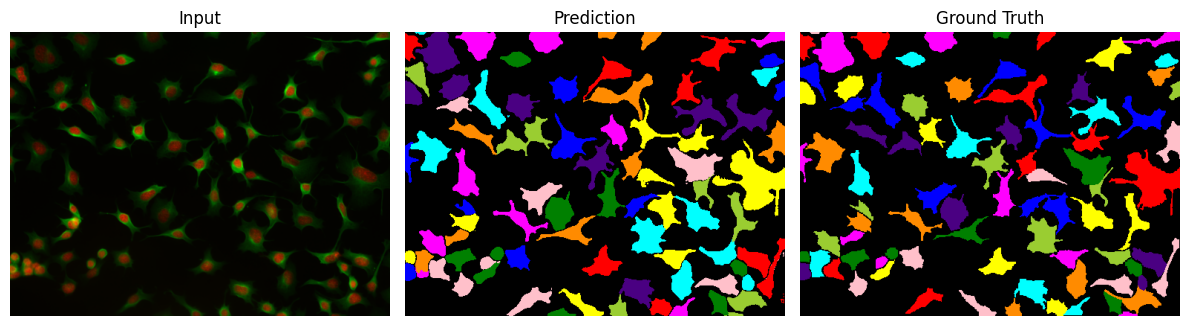

In [12]:
# lakukan prediksi dengan model yang di-load
image = imageio.imread(data_path/'test'/'000_img.png')
gt = imageio.imread(data_path/'test'/'000_masks.png')
model_output = predictor.module.apply(
    dict(params = predictor.params),
    image = image / 255,
)
pred = patches_to_label(
    model_output, 
    input_size=image.shape[:2]
)
pred = np.asarray(pred)

show_images([
    image,
    label2rgb(pred, bg_label=0),
    label2rgb(gt, bg_label=0),
])

titles = ['Input', "Prediction", "Ground Truth"]
[ax.set_title(title) for ax, title in zip(plt.gcf().get_axes(), titles)]

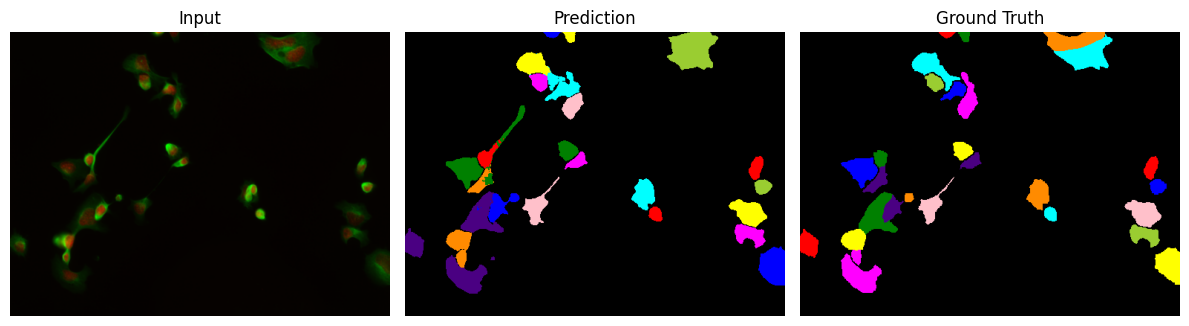

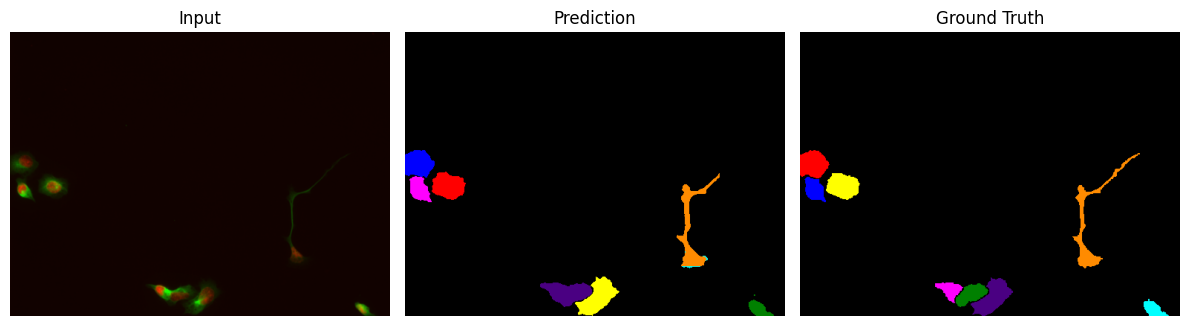

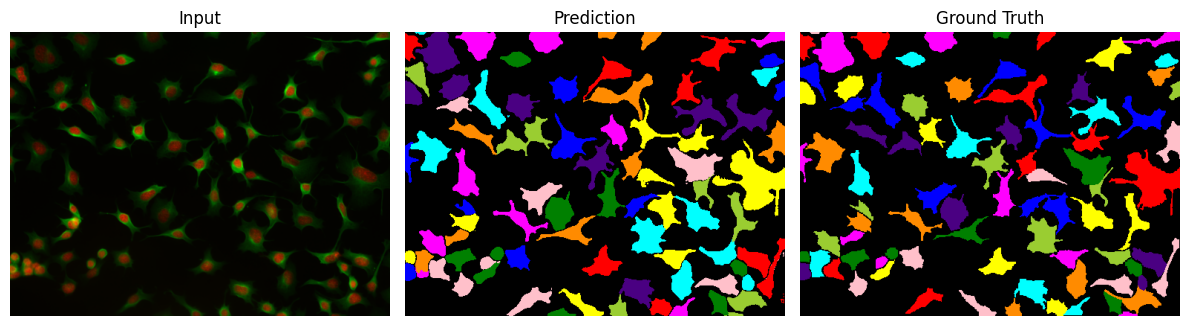

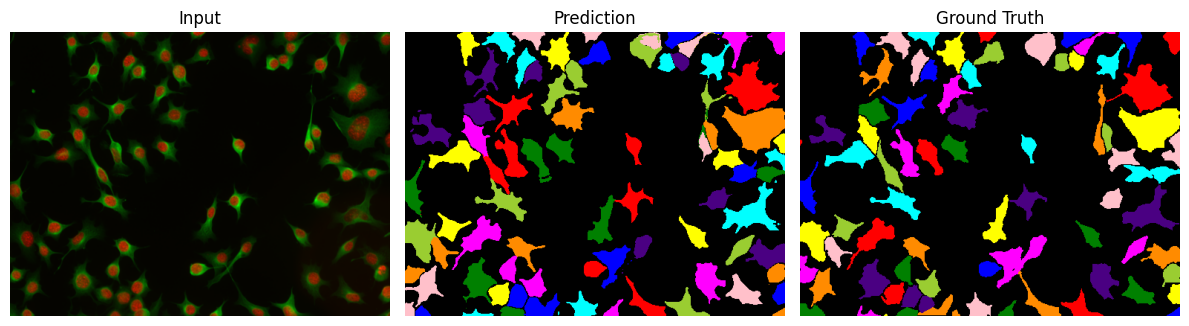

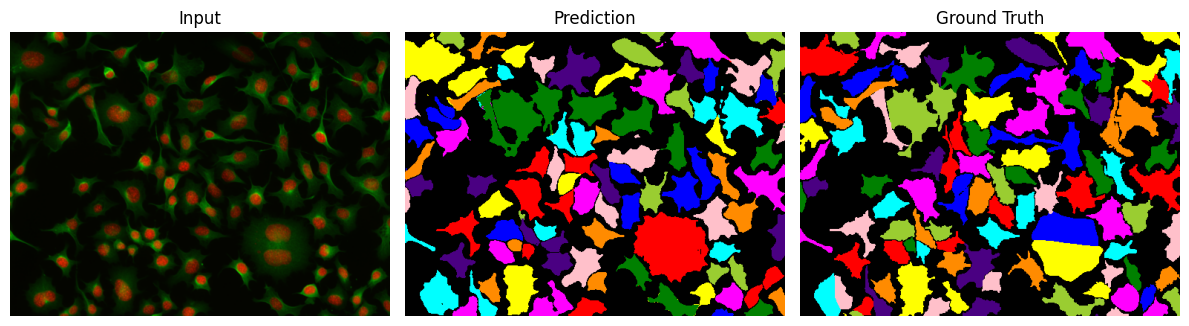

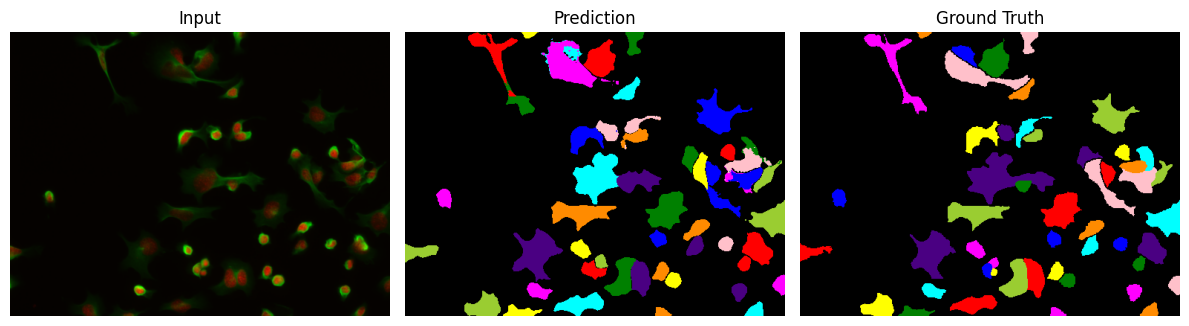

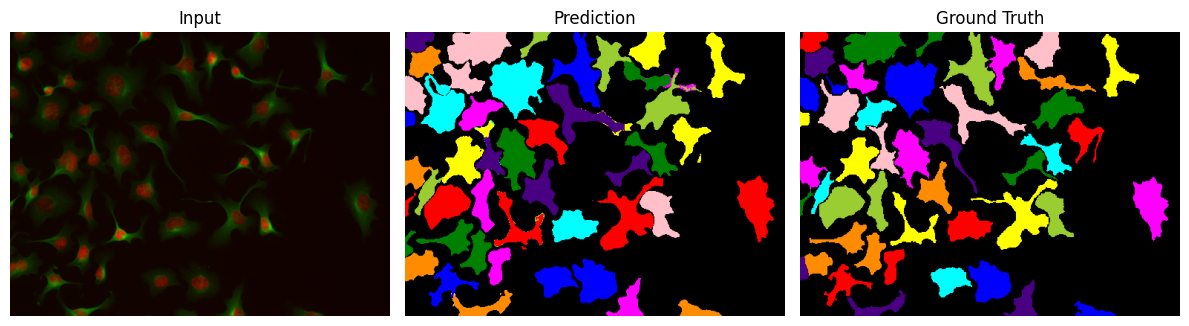

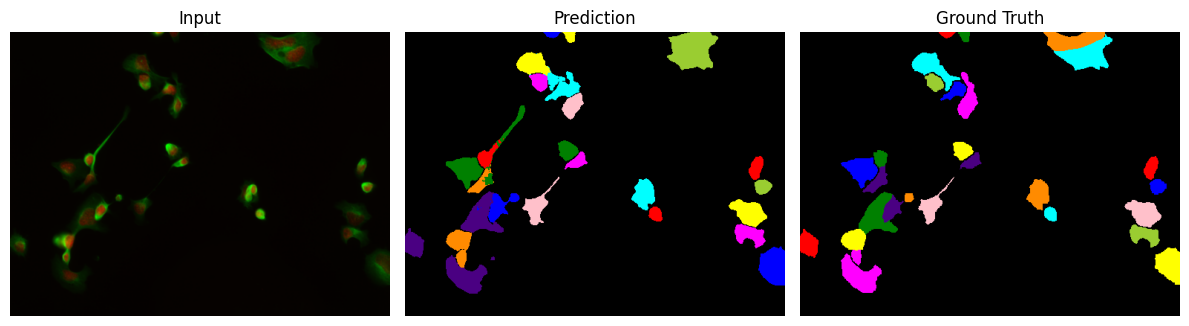

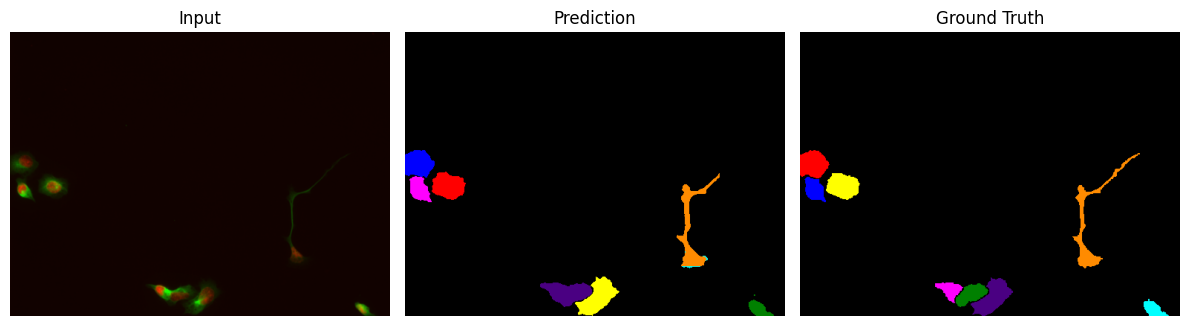

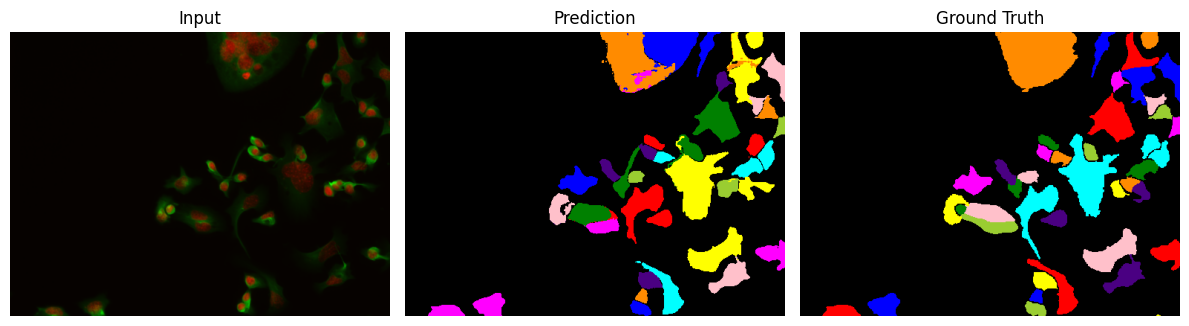

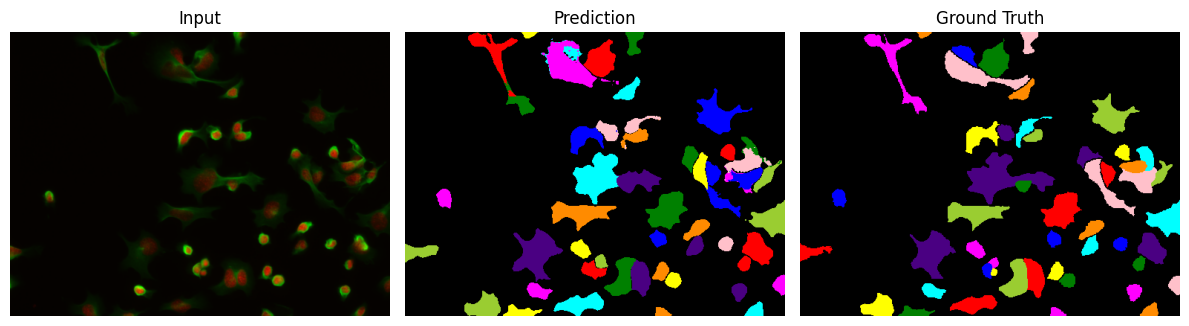

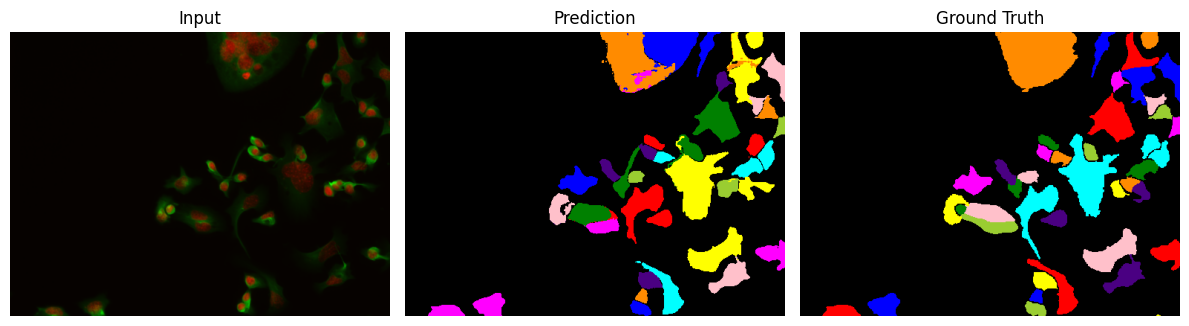

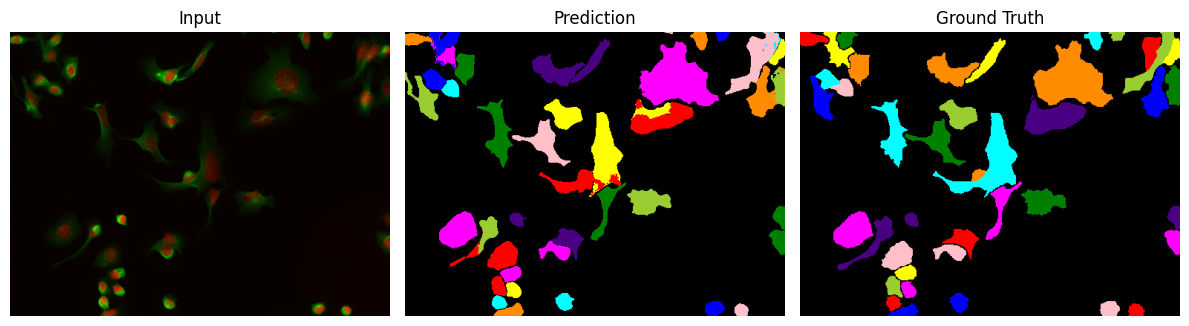

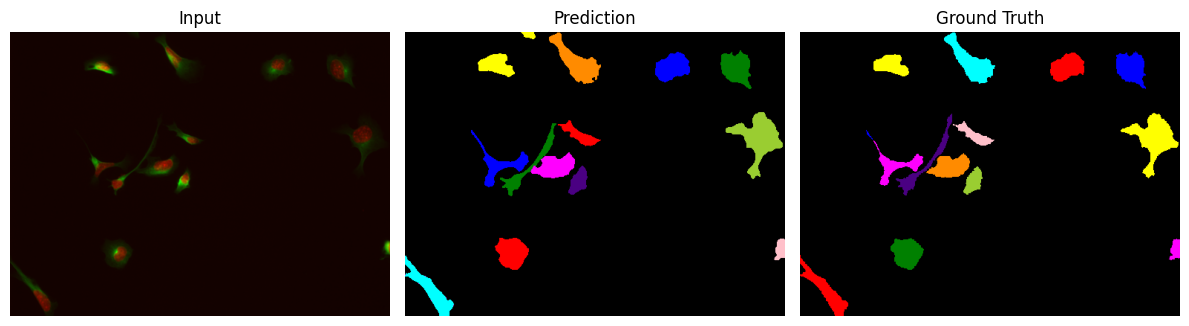

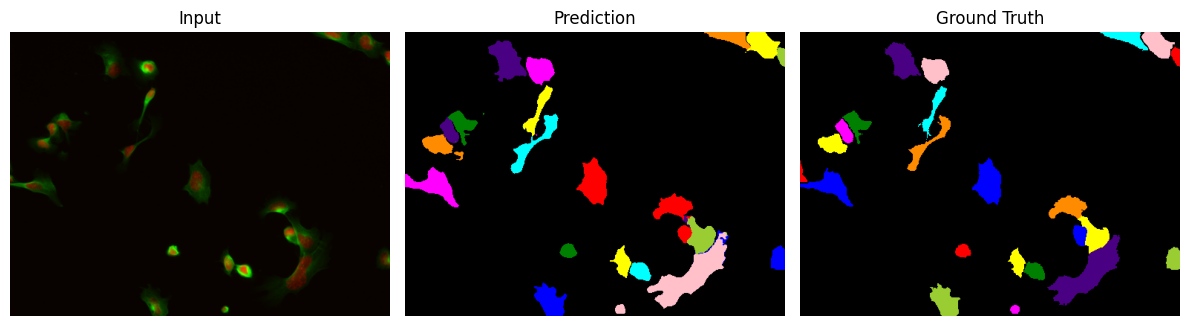

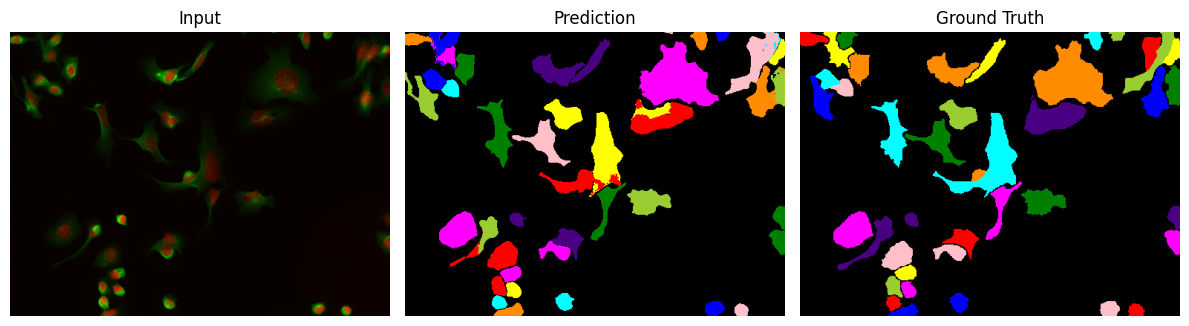

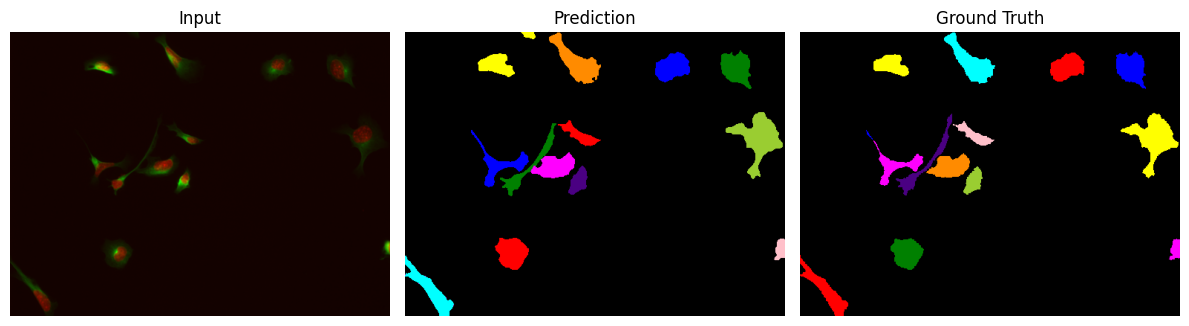

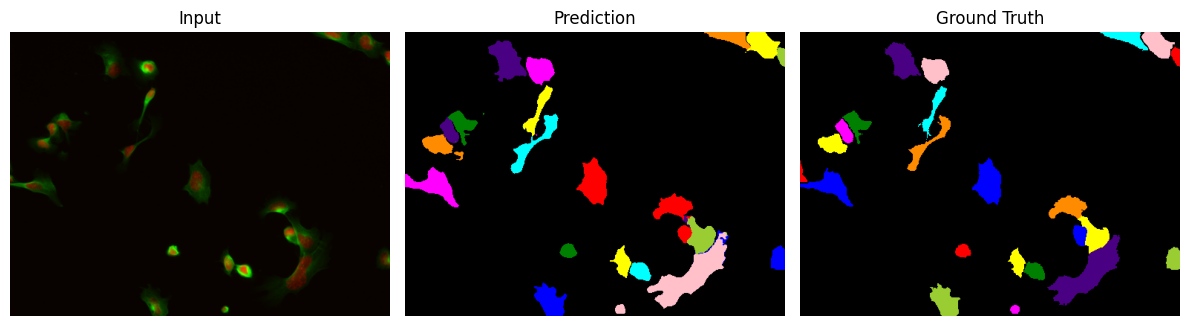

In [14]:
for i in range(11):
    # Uji pada 10 testing set
    image_number = str(i).zfill(3)
    image = imageio.imread(data_path/'test'/f'{image_number}_img.png')
    gt = imageio.imread(data_path/'test'/f'{image_number}_masks.png')

    model_output = predictor.module.apply(
        dict(params = predictor.params),
        image = image / 255,
    )
    pred = patches_to_label(
        model_output, 
        input_size=image.shape[:2]
    )
    pred = np.asarray(pred)

    show_images([
        image,
        label2rgb(pred, bg_label=0),
        label2rgb(gt, bg_label=0),
    ])

    titles = ['Input', "Prediction", "Ground Truth"]
    [ax.set_title(title) for ax, title in zip(plt.gcf().get_axes(), titles)]
    
    plt.show() # Display the plot for each image

## Watershed Segmentation

In [26]:
import cv2
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt
    
class Watershed:
    def __init__(self, image):
            # konversi gambar ke grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            self.gray = ~gray
    def segment(self):
            # thresholding menggunakan metode Otsu
            ret, bin_img = cv2.threshold(self.gray,
            							0, 255, 
            							cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            # menghilangkan noise
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
            bin_img = cv2.morphologyEx(bin_img, 
            						cv2.MORPH_OPEN,
            						kernel,
            						iterations=1)

            # mengambil distance transform pada binary image
            dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
            ret, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, cv2.THRESH_BINARY)
            sure_fg = sure_fg.astype(np.uint8) 
            # labeling pada piksel objek
            ret, markers = cv2.connectedComponents(sure_fg)
            unknown = cv2.subtract(sure_bg, sure_fg)
            # melakukan masking untuk background
            markers += 1
            markers[unknown == 255] = 0
            
            # watershed Algorithm
            
            # menggunakan binary image untuk diolah menggunakan watershed
            binary = cv2.cvtColor(bin_img, cv2.COLOR_GRAY2RGB)
            
            markers = cv2.watershed(binary, markers)
            
            # merapihkan marker
            markers = markers - 1
            markers[markers<0] = 0
            return markers

[Text(0.5, 1.0, 'Input'),
 Text(0.5, 1.0, 'Prediction'),
 Text(0.5, 1.0, 'Ground Truth')]

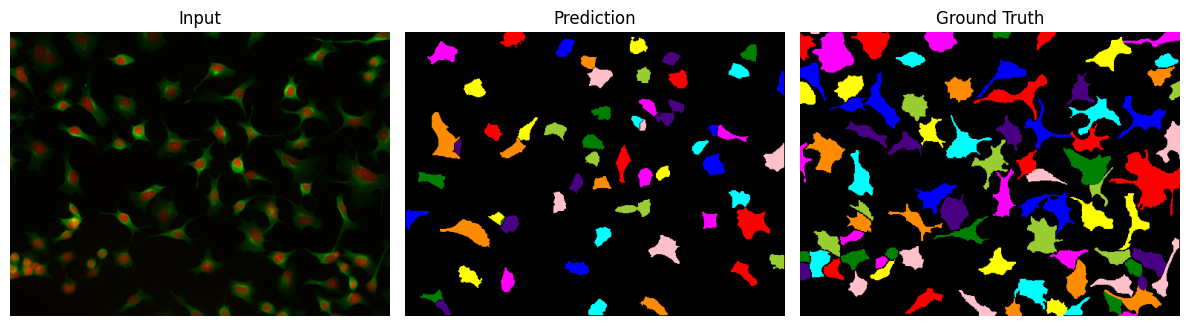

In [30]:
# Lakukan prediksi hasil pada binary image
image = imageio.imread(data_path/'test'/'000_img.png')
gt = imageio.imread(data_path/'test'/'000_masks.png')
segmentor = Watershed(img)
mark = segmentor.segment()

mark = np.asarray(mark)

show_images([
    image,
    label2rgb(mark, bg_label=0),
    label2rgb(gt, bg_label=0),
])

titles = ['Input', "Prediction", "Ground Truth"]
[ax.set_title(title) for ax, title in zip(plt.gcf().get_axes(), titles)]

In [ ]:
for i in range(11):
    # uji prediksi pada 10 gambar pada testing set
    image_number = str(i).zfill(3)
    image = imageio.imread(data_path/'test'/f'{image_number}_img.png')
    gt = imageio.imread(data_path/'test'/f'{image_number}_masks.png')

    segmentor = Watershed(image)
    mark = segmentor.segment()
    
    mark = np.asarray(mark)

    show_images([
        image,
        label2rgb(mark, bg_label=0),
        label2rgb(gt, bg_label=0),
    ])

    titles = ['Input', "Prediction", "Ground Truth"]
    [ax.set_title(title) for ax, title in zip(plt.gcf().get_axes(), titles)]
    
    plt.show()

## Membandingkan keduanya

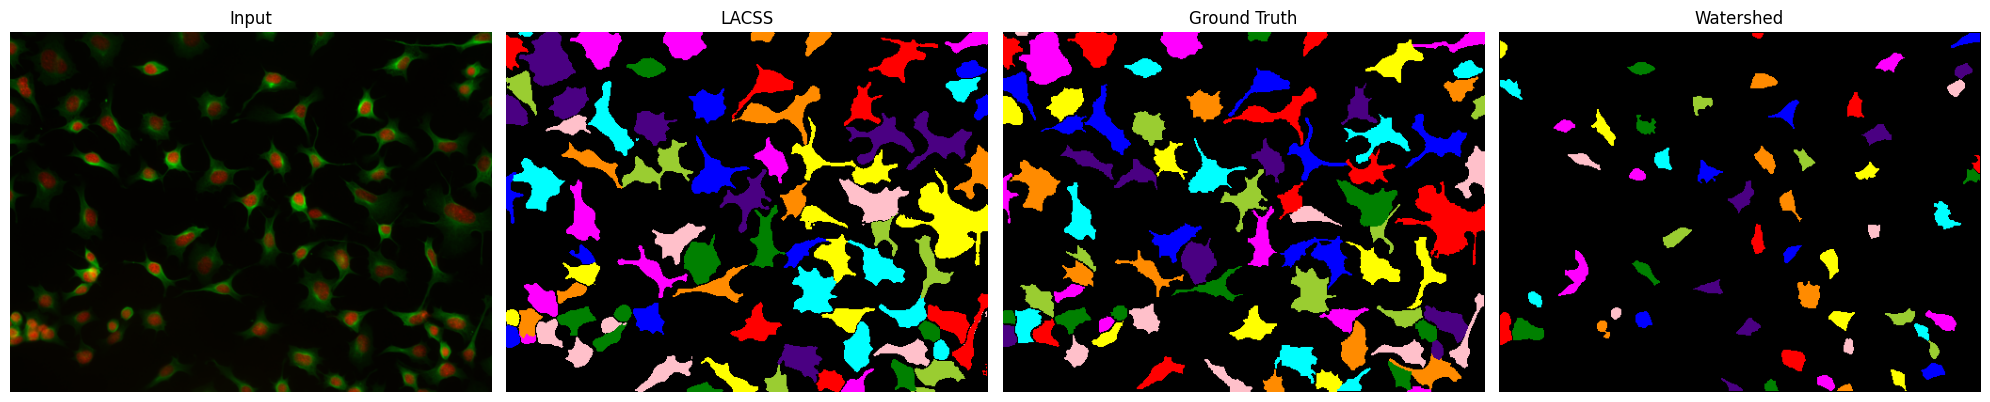

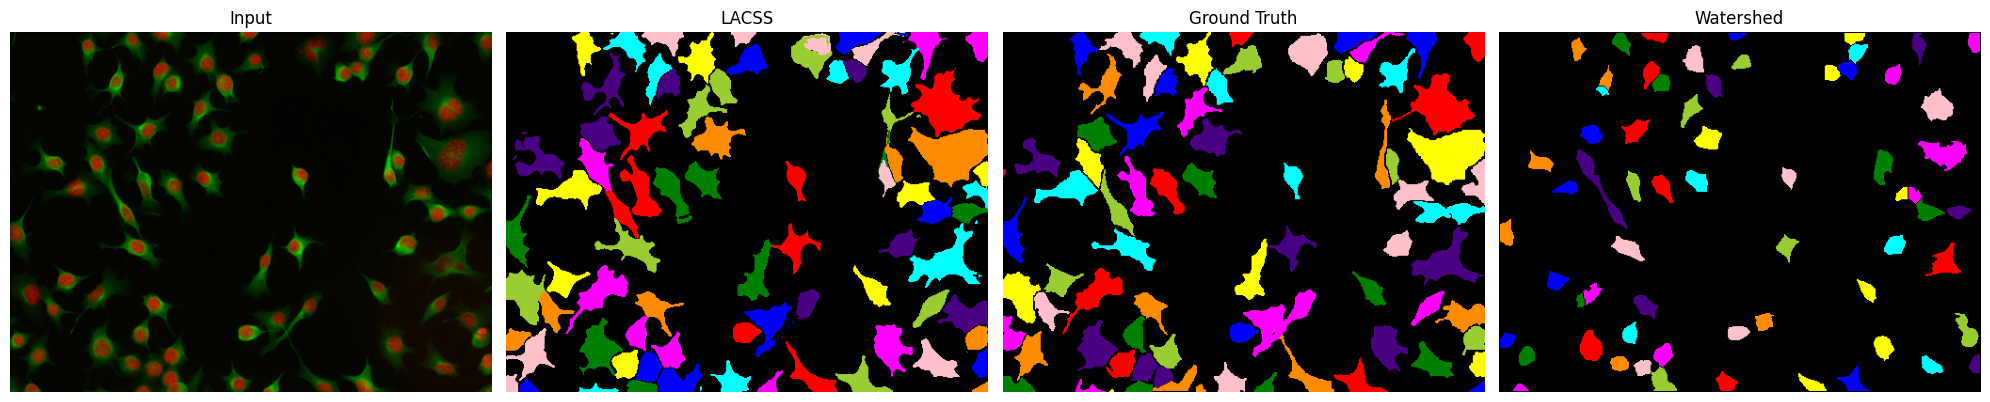

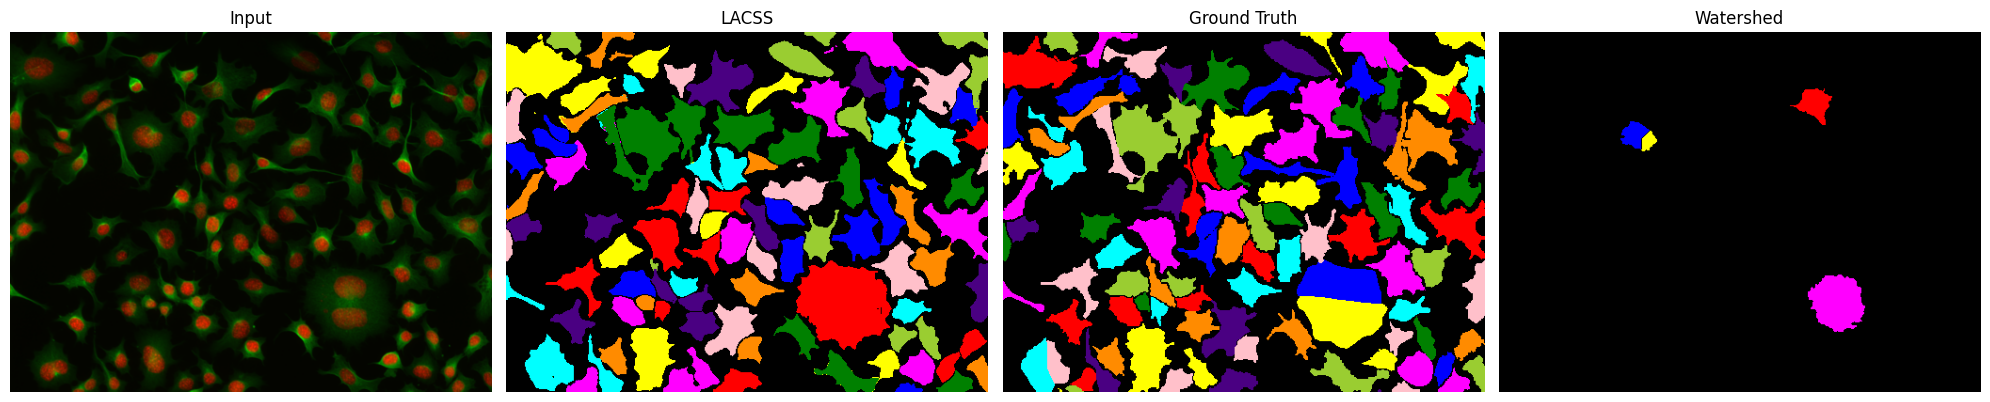

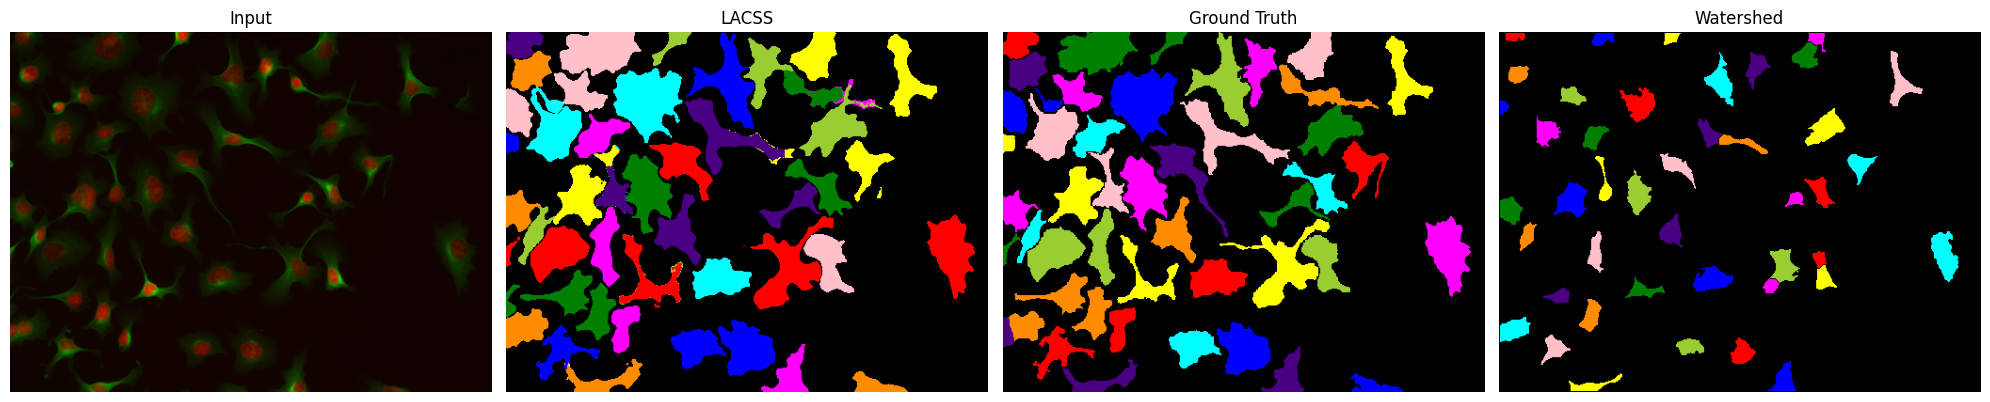

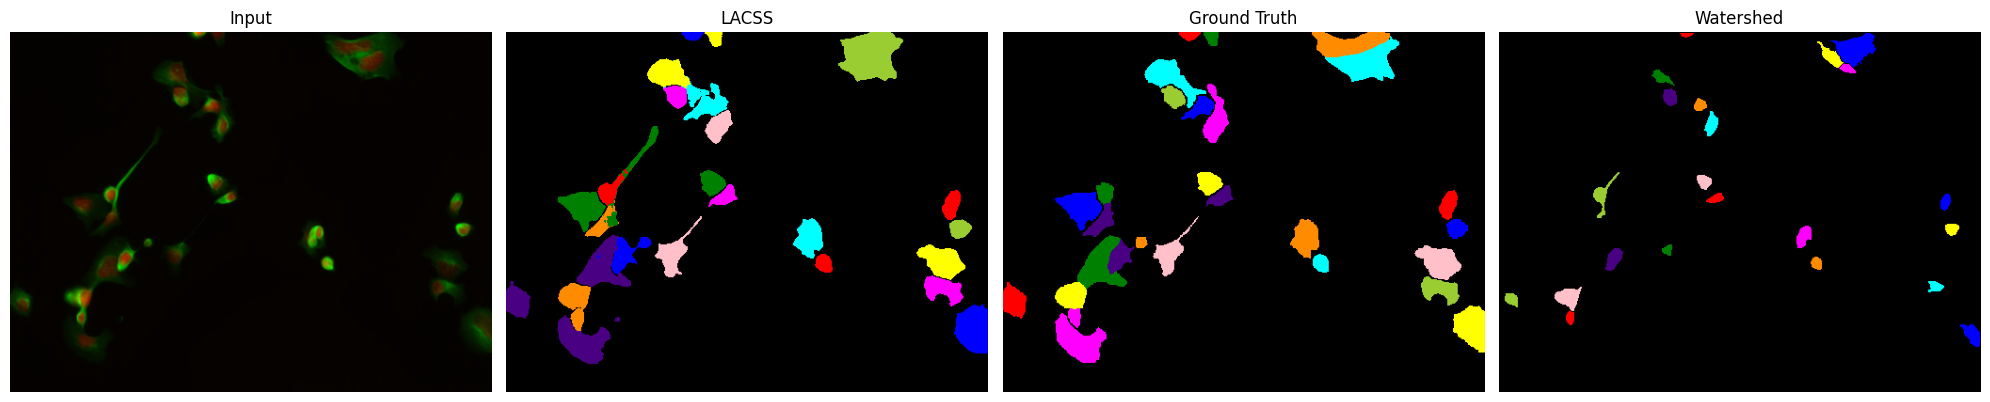

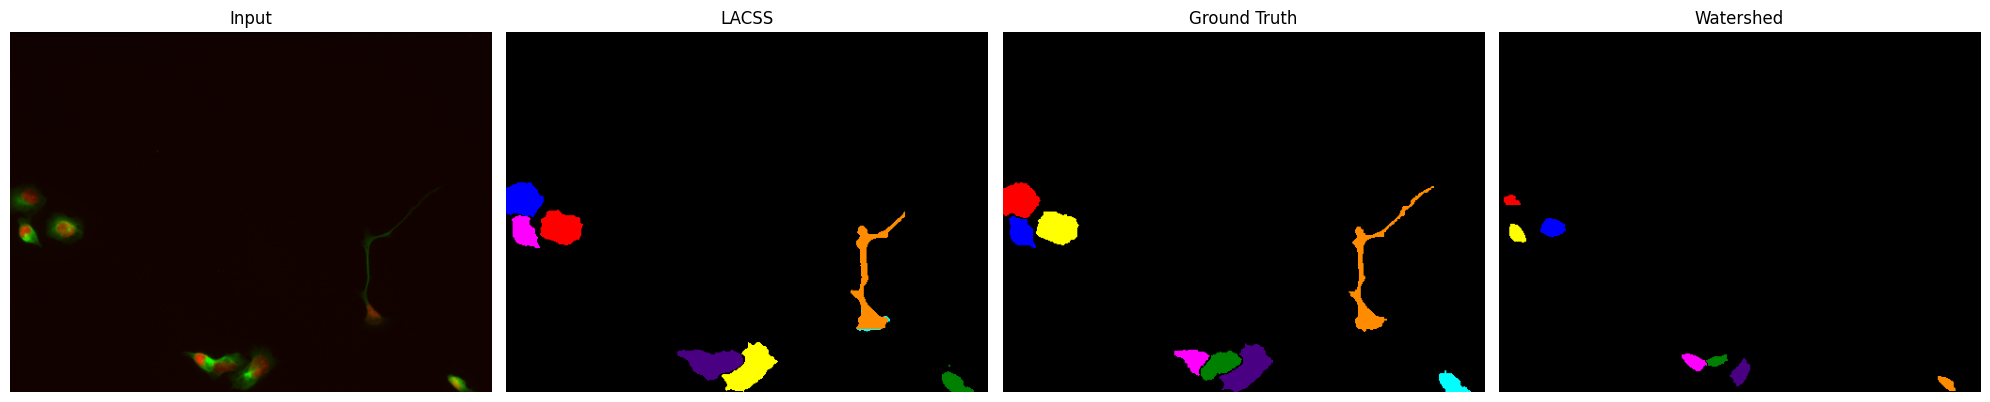

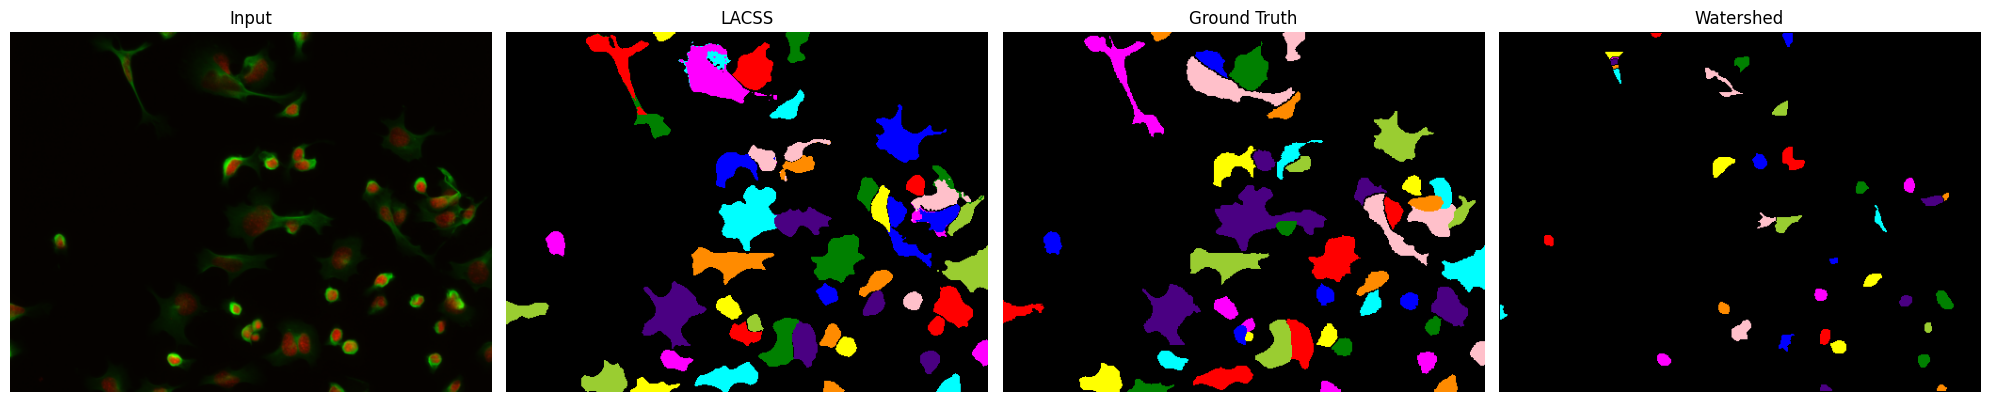

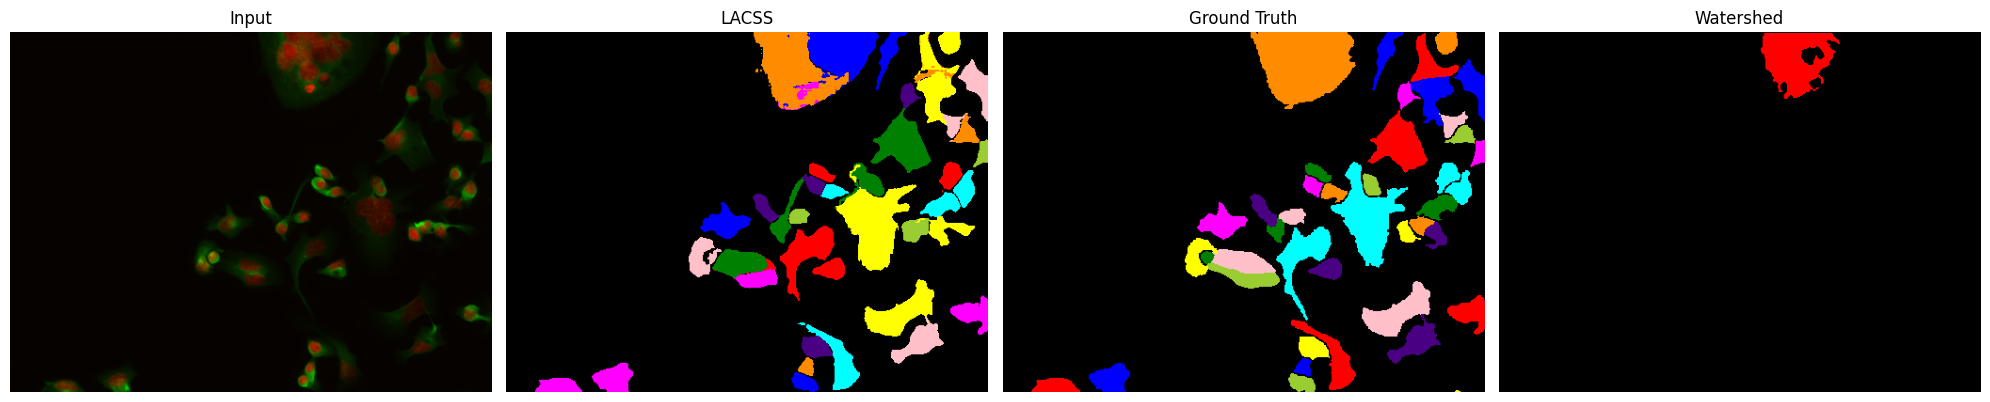

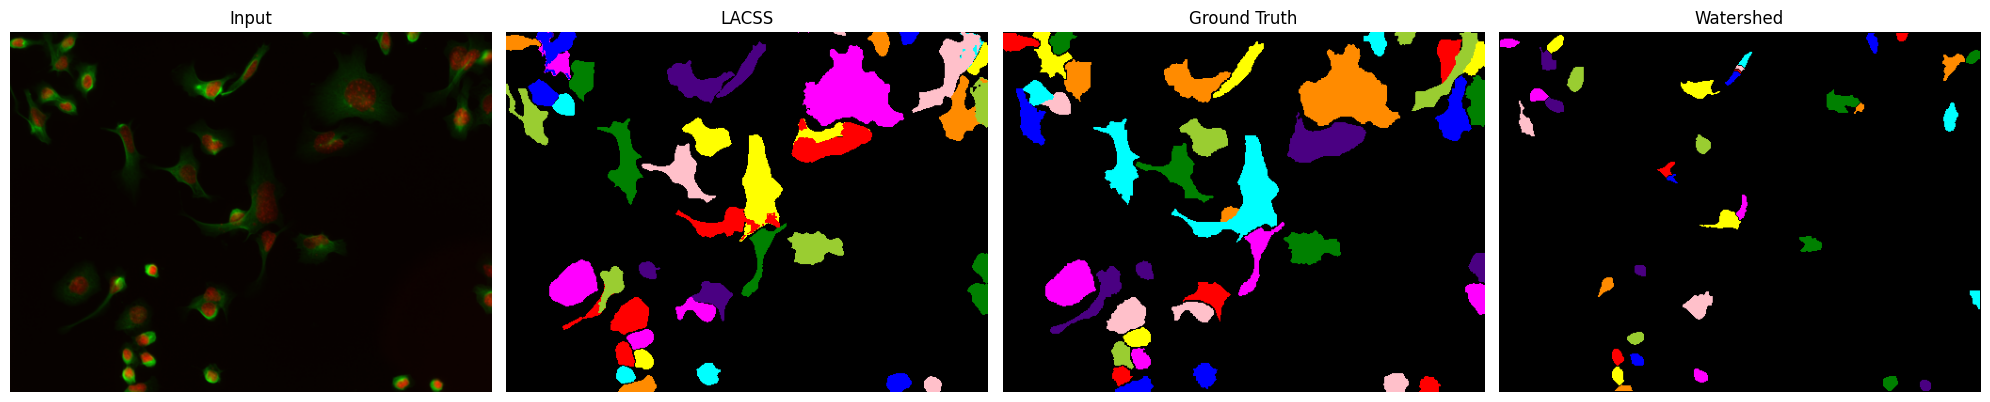

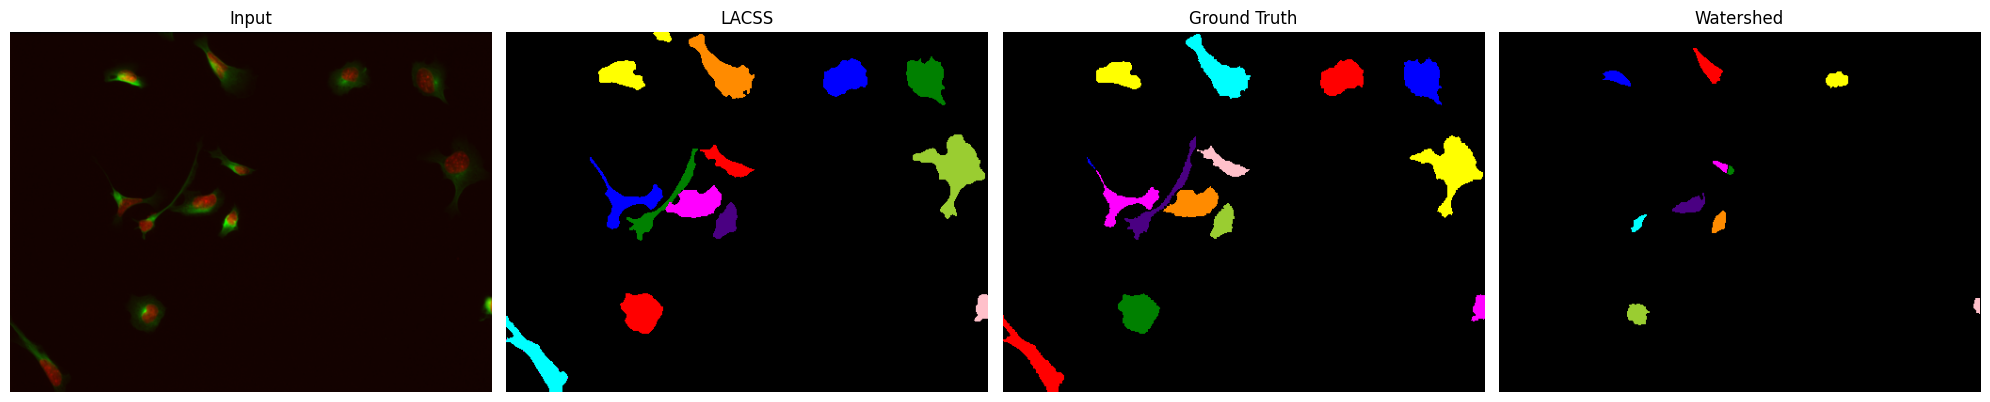

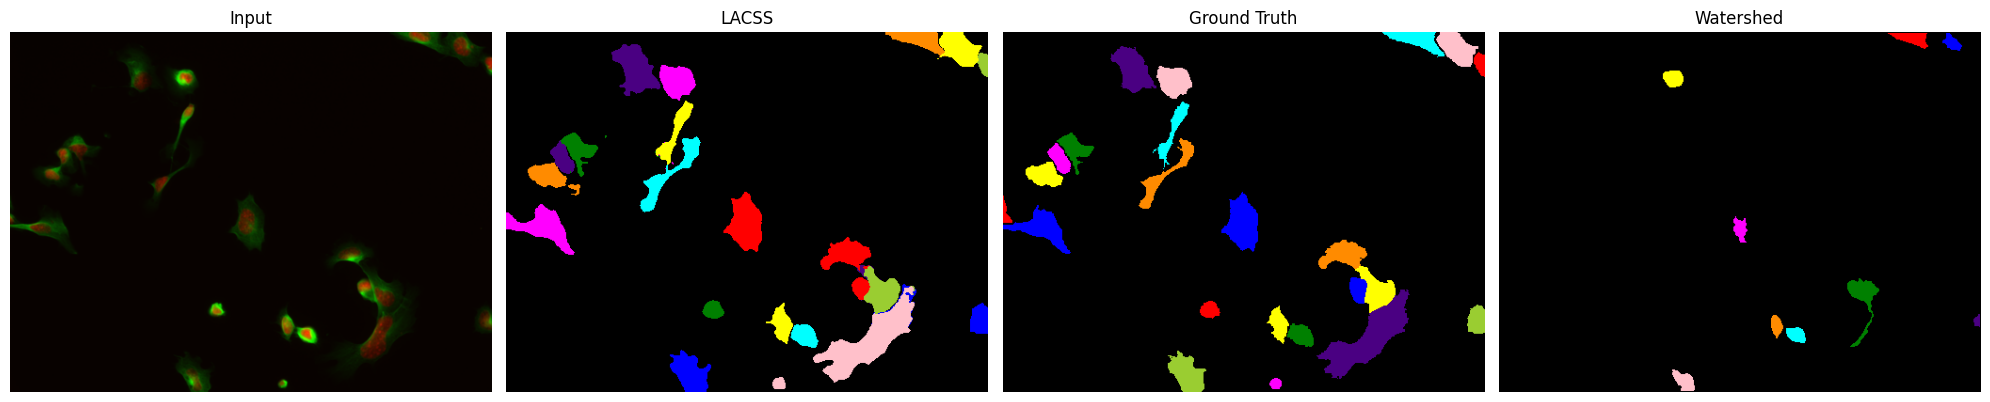

In [38]:
for i in range(11):
    # Prediksi pada 10 gambar testing set
    image_number = str(i).zfill(3)
    image = imageio.imread(data_path / 'test' / f'{image_number}_img.png')
    gt = imageio.imread(data_path / 'test' / f'{image_number}_masks.png')

    # LACSS Prediction
    model_output = predictor.module.apply(
        dict(params=predictor.params),
        image=image / 255,
    )
    dl_pred = patches_to_label(
        model_output,
        input_size=image.shape[:2]
    )
    dl_pred = np.asarray(dl_pred)

    # Watershed Prediction
    segmentor = Watershed(image)
    ws_pred = segmentor.segment()
    ws_pred = np.asarray(ws_pred)

    # Hasil
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    images = [image, label2rgb(dl_pred, bg_label=0), 
              label2rgb(gt, bg_label=0), label2rgb(ws_pred, bg_label=0)]
    titles = ['Input', "LACSS", "Ground Truth", "Watershed"]

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(title)

    plt.tight_layout()
    plt.show()
   